<div align="center">

# Projet de Trading avec Machine Learning 

Le projet consiste à élaborer une stratégie de trading qui sera flat/longue sur l’action Amazon grâce à l’utilisation du Machine Learning et de différents algorithmes de classification pour pouvoir observer le comportement de notre stratégie dans la vie réelle sur les données historiques d'Amazon.

</div>

 ## <font color='brown' face='Time New Roman'>1. Importation de la base de données</font>

**<font color='green' face='Time New Roman'>Installation et Importation des Packages**

In [104]:
pip install ta

You should consider upgrading via the 'c:\Users\BUNICE\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [50]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [252]:
!pip install optuna

     ------------------------------------ 413.4/413.4 KB 478.3 kB/s eta 0:00:00
     ------------------------------------ 233.4/233.4 KB 475.9 kB/s eta 0:00:00
     ---------------------------------------- 2.1/2.1 MB 486.7 kB/s eta 0:00:00
     -------------------------------------- 78.3/78.3 KB 436.3 kB/s eta 0:00:00
     ------------------------------------ 145.3/145.3 KB 480.8 kB/s eta 0:00:00
     -------------------------------------- 78.7/78.7 KB 438.6 kB/s eta 0:00:00
     ------------------------------------ 292.3/292.3 KB 474.9 kB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\BUNICE\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [253]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ta
import seaborn as sns
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report,accuracy_score,mean_squared_error,r2_score, mean_absolute_error,confusion_matrix, ConfusionMatrixDisplay,recall_score,RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

**<font color='green' face='Time New Roman'>Création de la base de données**

In [2]:
df = pd.read_csv("AMAZON.csv", index_col=0)
df.tail()  # Affichage des 5 derniéres lignes

,Date,Close
6448,2022-12-28,81.82
6449,2022-12-29,84.18
6450,2022-12-30,84.00
6451,2023-01-03,85.82
6452,2023-01-04,85.14


 ## <font color='brown' face='Time New Roman'>2. Preprocessing de la base de données et Visualisation</font>

**<font color='green' face='Time New Roman'>Conversion Définition de l'Index**

In [3]:
# Convertir la colonne de date au format datetime
df['Date'] = pd.to_datetime(df['Date'])

# Définir la colonne de date comme index
df = df.set_index('Date')

**<font color='green' face='Time New Roman'>Description et ajout des Principaux Indicateurs Techniques**

<div align="center">

<span style="color:navy; font-weight:bold">SMA :</span> *L'ajout de SMA avec des périodes différentes offre une vue multidimensionnelle de l'évolution des prix, capturant à la fois les tendances à court et à long terme. C'est un outil polyvalent utilisé par les analystes techniques pour prendre des décisions éclairées sur les tendances du marché et les opportunités de trading potentielles.*

<span style="color:navy; font-weight:bold">RSI :</span> *Le RSI est un oscillateur de momentum qui mesure la vitesse et le changement des mouvements de prix, avec une période par défaut courante de 14. Une période de 20 suggère une vision à plus long terme pour le RSI.*

<span style="color:navy; font-weight:bold">Les Bandes de Bollinger :</span> *Les Bandes de Bollinger sont un outil d'analyse technique utilisé pour évaluer la volatilité et identifier les conditions de surachat ou de survente sur un marché financier. Lorsque les prix restent principalement à l'intérieur des bandes, cela suggère une période de stabilité ou de consolidation, tandis que des bandes étroites signalent une faible volatilité et une possible augmentation imminente de la volatilité.*

<span style="color:navy; font-weight:bold">MACD Line (Bleue) :</span> *Lorsque la ligne MACD (bleue) est au-dessus de la ligne zéro, cela indique que la tendance à court terme est haussière. Lorsque la ligne MACD est en dessous de la ligne zéro, cela indique une tendance à court terme baissière. Recherchez les croisements avec la ligne de signal comme points d'entrée ou de sortie potentiels.*

<span style="color:navy; font-weight:bold">Signal Line (Rouge) :</span> *Lorsque la ligne de signal (rouge) est au-dessus de la ligne zéro et que la ligne MACD la croise par le haut, cela génère un signal haussier. Lorsque la ligne de signal est en dessous de la ligne zéro et que la ligne MACD la croise par le bas, cela génère un signal baissier. La distance entre la ligne MACD et la ligne de signal donne des indications sur la force de la tendance.*

</div>


In [4]:
# Ajout des indicateurs SMA, RSI, MACD à notre base de donnes
df['SMA'] = ta.trend.sma_indicator(df['Close'], window=20)
df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
df['UpperBB'], df['MiddleBB'], df['LowerBB'] = ta.volatility.bollinger_hband(df['Close'], window=20, window_dev=2), ta.volatility.bollinger_mavg(df['Close'], window=20), ta.volatility.bollinger_lband(df['Close'], window=20, window_dev=2)
df['MACD'] = ta.trend.macd_diff(df['Close'], window_slow=26, window_fast=12)
df['Ema'] = ta.trend.ema_indicator(df['Close'], window=20)
# Calcul de la moyenne mobile exponentielle (EMA) pour les prix de clôture
ema_close = df["Close"].ewm(span=30, adjust=False).mean()

# Calcul de l'écart type mobile exponentiellement pondéré (EWMA) pour les prix de clôture
ewma_std_close = df["Close"].ewm(span=30, adjust=False).std()

# Calcul du score Z en utilisant l'EMA et l'EWMA pour la normalisation
df['zscore'] = (df["Close"] - ema_close) / ewma_std_close

# Remplacer les valeurs NaN par 0
df['zscore'] = df['zscore'].replace(np.nan, 0)

*Calcul des returns à l'aide de cette formule :*
<div align="center">

$ \text{Percentage Change} = \frac{P_t - P_{t-1}}{P_{t-1}} \times 100 $

</div>

In [5]:
df=df.dropna()
df['returns'] = df['Close'].pct_change().dropna() # Nous calculons la variation quotidienne en pourcentage des prix de clôture (P_t)
df['Label'] = (df['returns'] > 0).astype(int) # Nous rajoutons le label qui vaut 1 si returns > 0 et 0 sinon
df

,Close,SMA,RSI,UpperBB,MiddleBB,LowerBB,MACD,Ema,zscore,returns,Label
Date,,,,,,,,,,,
1997-07-02,19.068,18.5934,51.849571,19.857302,18.5934,17.329498,0.156128,18.595152,0.043057,NaN,0
1997-07-03,22.932,18.8148,71.749955,21.087347,18.8148,16.542253,0.437937,19.008186,1.877580,0.202643,1
1997-07-07,24.000,19.0212,74.844603,22.206760,19.0212,15.835640,0.663961,19.483596,1.984004,0.046572,1
1997-07-08,27.624,19.3896,82.035806,24.298938,19.3896,14.480262,1.004776,20.258873,2.545958,0.151000,1
1997-07-09,27.876,19.8336,82.412315,25.972482,19.8336,13.694718,1.182190,20.984314,2.102889,0.009123,1
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28,81.820,88.7520,33.176586,96.729096,88.7520,80.774904,-0.238757,88.147535,-0.407201,-0.014692,0
2022-12-29,84.180,88.1340,39.111495,95.493104,88.1340,80.774896,-0.098272,87.769674,-0.289946,0.028844,1
2022-12-30,84.000,87.5590,38.828239,94.296976,87.5590,80.821024,0.014425,87.410658,-0.287684,-0.002138,0


In [15]:
df=df.iloc[1:] # enlevons  la premiere ligne car returns egale à NAN value
df

,Close,SMA,RSI,UpperBB,MiddleBB,LowerBB,MACD,Ema,zscore,returns,Label
Date,,,,,,,,,,,
1997-07-07,24.000,19.0212,74.844603,22.206760,19.0212,15.835640,0.663961,19.483596,1.984004,0.046572,1
1997-07-08,27.624,19.3896,82.035806,24.298938,19.3896,14.480262,1.004776,20.258873,2.545958,0.151000,1
1997-07-09,27.876,19.8336,82.412315,25.972482,19.8336,13.694718,1.182190,20.984314,2.102889,0.009123,1
1997-07-10,30.756,20.4462,86.018835,28.172192,20.4462,12.720208,1.412906,21.914950,2.258926,0.103315,1
1997-07-11,27.504,20.8590,68.850460,29.146624,20.8590,12.571376,1.270385,22.447241,1.342907,-0.105735,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-28,81.820,88.7520,33.176586,96.729096,88.7520,80.774904,-0.238757,88.147535,-0.407201,-0.014692,0
2022-12-29,84.180,88.1340,39.111495,95.493104,88.1340,80.774896,-0.098272,87.769674,-0.289946,0.028844,1
2022-12-30,84.000,87.5590,38.828239,94.296976,87.5590,80.821024,0.014425,87.410658,-0.287684,-0.002138,0


**<font color='green' face='Time New Roman'>Traçage du graphique des rendements**

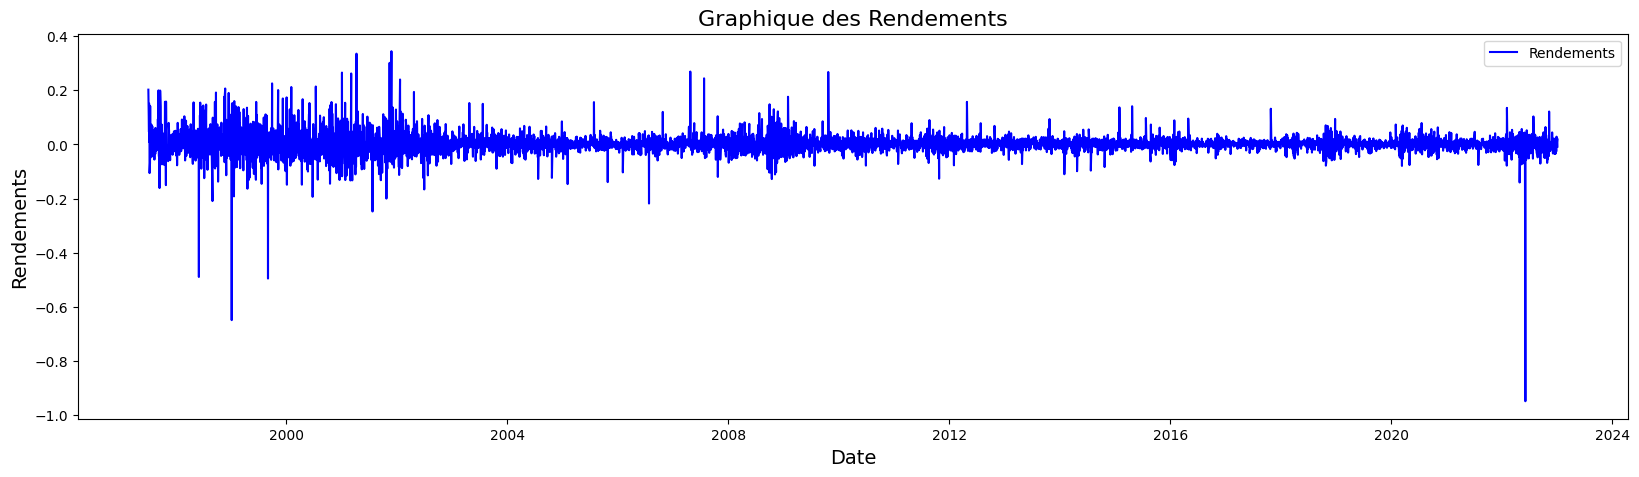

In [111]:
plt.figure(figsize=(20, 5))
plt.plot(df['returns'], color='blue', linewidth=1.5, label='Rendements')
plt.title('Graphique des Rendements', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Rendements', fontsize=14)
plt.legend(loc='upper right')
plt.show()

**<font color='green' face='Time New Roman'>Traçage de l'histogramme des labels**

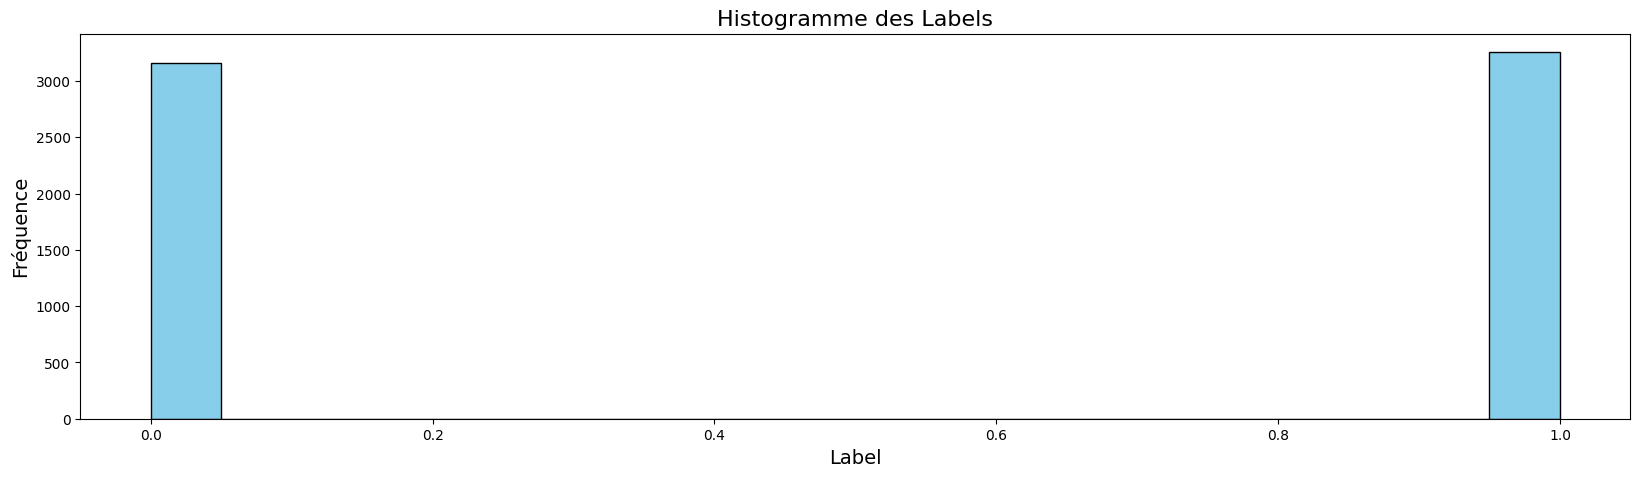

In [112]:

plt.figure(figsize=(20, 5))
plt.hist(df['Label'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogramme des Labels', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)
plt.show()

**<font color='green' face='Time New Roman'>Distribution des Rendements avec Médiane Soulignée**

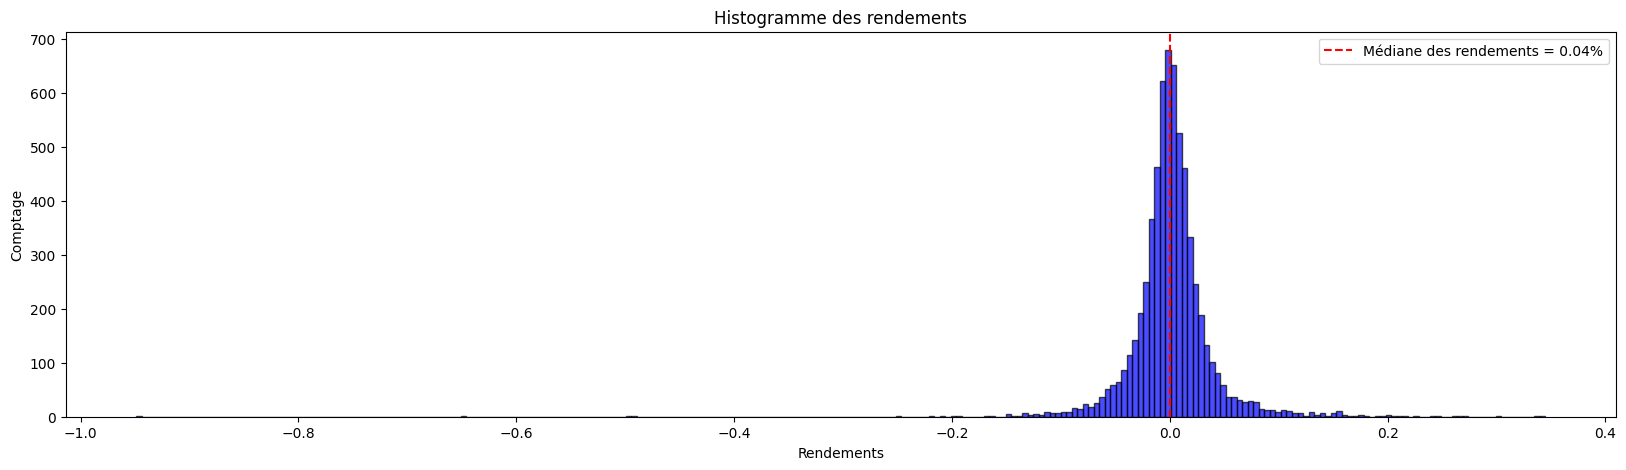

In [13]:
# Calcul de la médiane des rendements
median_return = np.median(df['returns'])

# Configuration de la taille du graphique
plt.figure(figsize=(20,5))

# Création de l'histogramme des rendements
plt.hist(df["returns"], bins=256, color='blue', edgecolor='black', alpha=0.7)  # alpha pour la transparence

# Ajout d'une ligne verticale pour la médiane
plt.axvline(median_return, color='red', linestyle='--', linewidth=1.5, label=f"Médiane des rendements = {(median_return*100).round(2)}%")

# Configuration des étiquettes et du titre
plt.xlabel("Rendements")
plt.ylabel("Comptage")
plt.title("Histogramme des rendements")

# Ajout d'une légende
plt.legend()

# Affichage du graphique
plt.show()

**<font color='green' face='Time New Roman'>Visualisation de la Dynamique du Marché : États Haussiers en Vert et Corrections en Rouge**

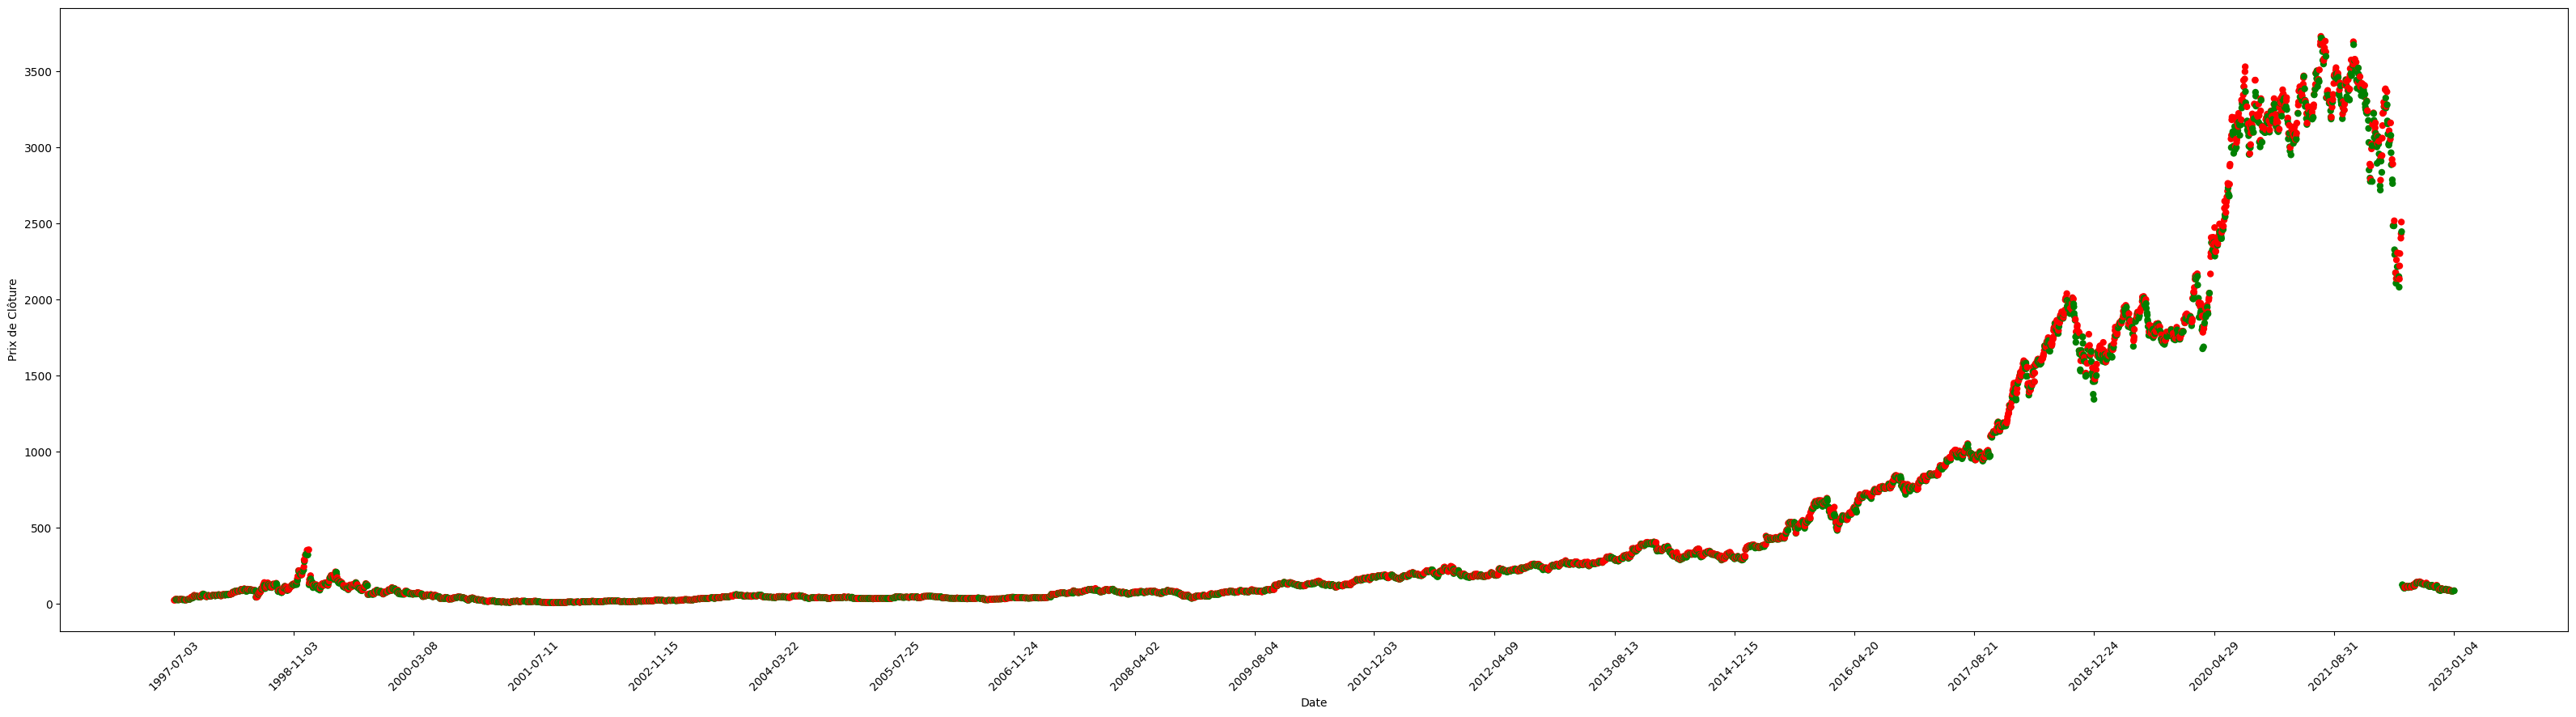

In [14]:
# Initialisation de la liste des couleurs en fonction de l'état du marché
# Green 'g' pour le marché stable/haussier, Rouge ('r') pour le marché en correction/crash
col = ['g' if label == 0 else 'r' for label in df["Label"]]

# Création d'une liste d'indices pour les marques sur l'axe des x
indx = np.linspace(0, len(df)-1, 20, dtype=int)  # 20 marques espacées uniformément
xticks = [df.index.values[i] for i in indx]  

# Configuration et affichage du scatter plot
plt.figure(figsize=(40,10))  # Taille du graphique pour une meilleure visibilité
plt.scatter(df.index, df["Close"], c=col, linewidth=0) 

# Configuration des marques sur l'axe des x avec rotation pour une meilleure lisibilité
plt.xticks(df.index.values[indx], rotation=45)

# Ajout des étiquettes des axes
plt.xlabel("Date")
plt.ylabel("Prix de Clôture")

# Affichage du graphique
plt.show()

**<font color='green' face='Time New Roman'>Traçage prix de cloture et des indicateurs**

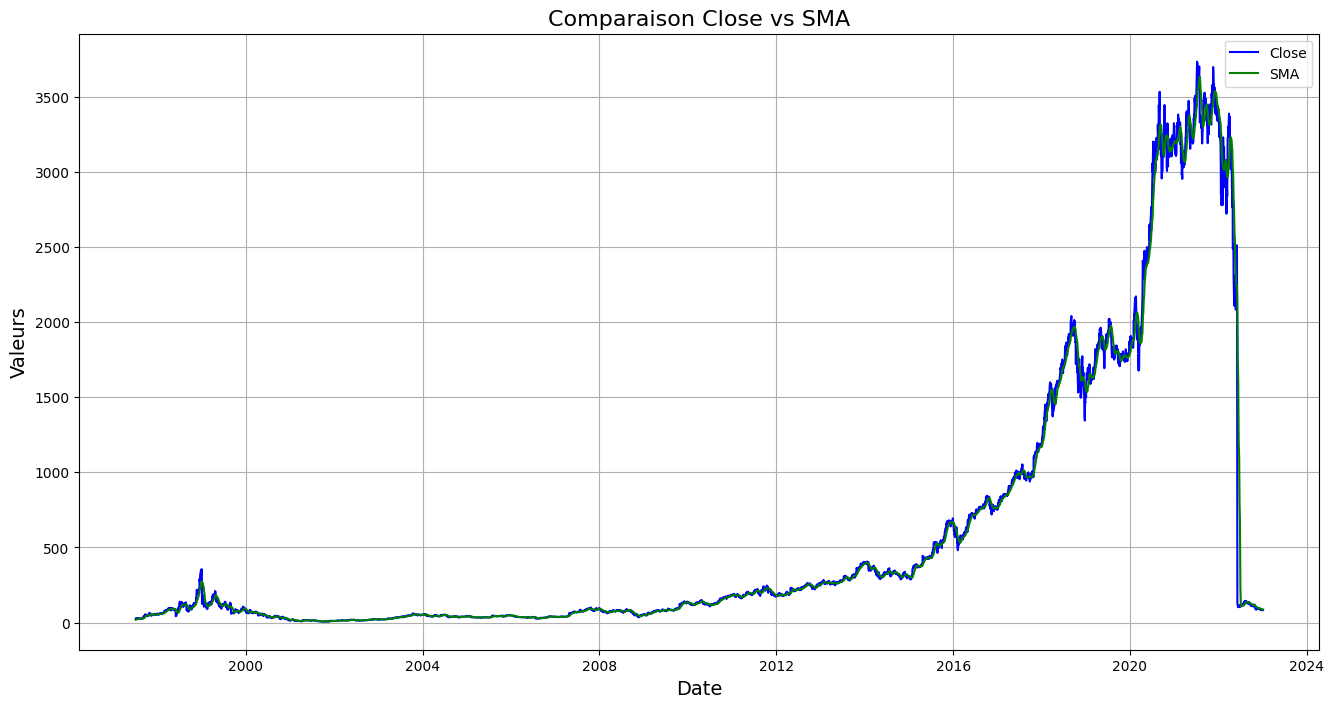

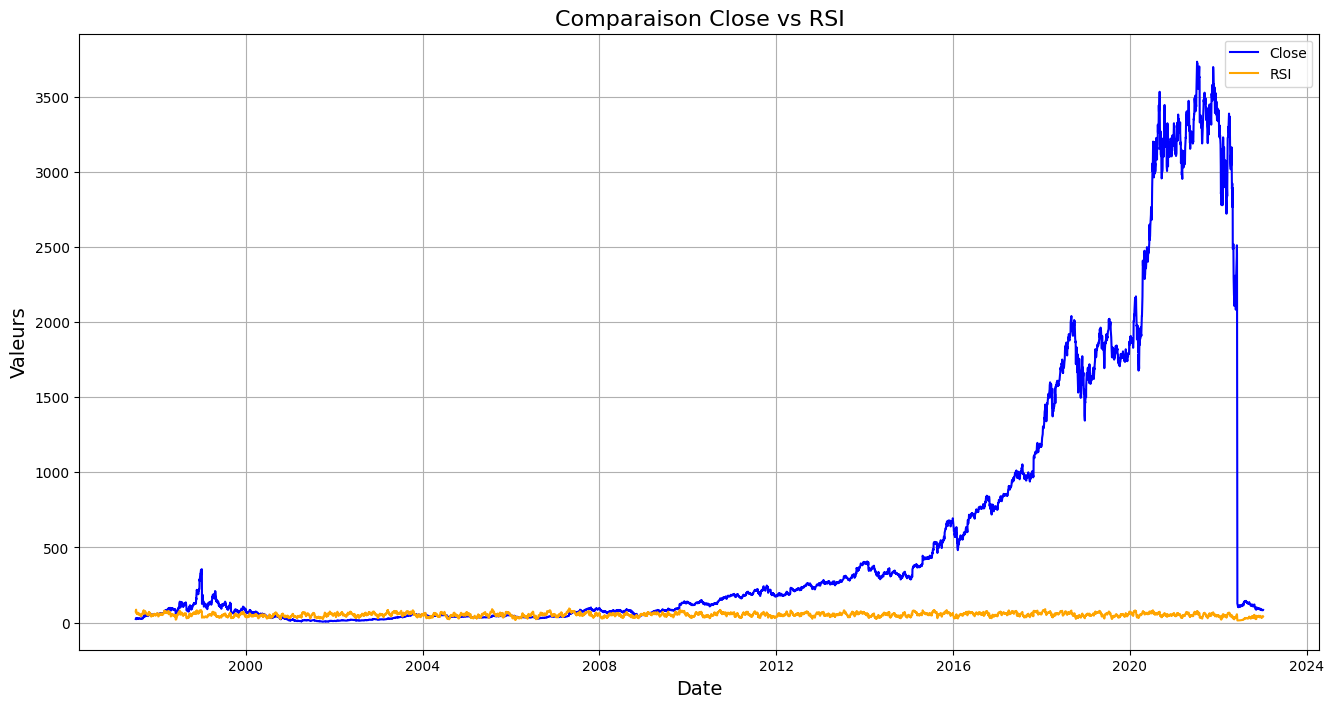

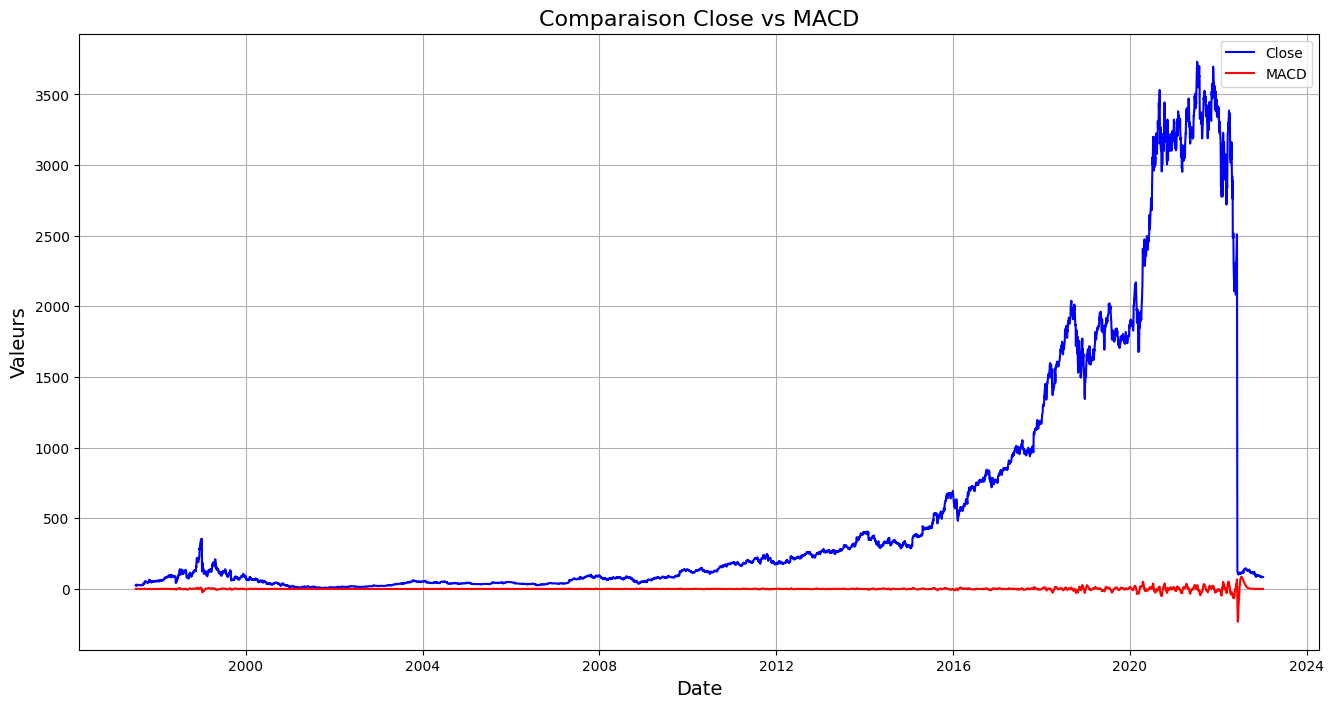

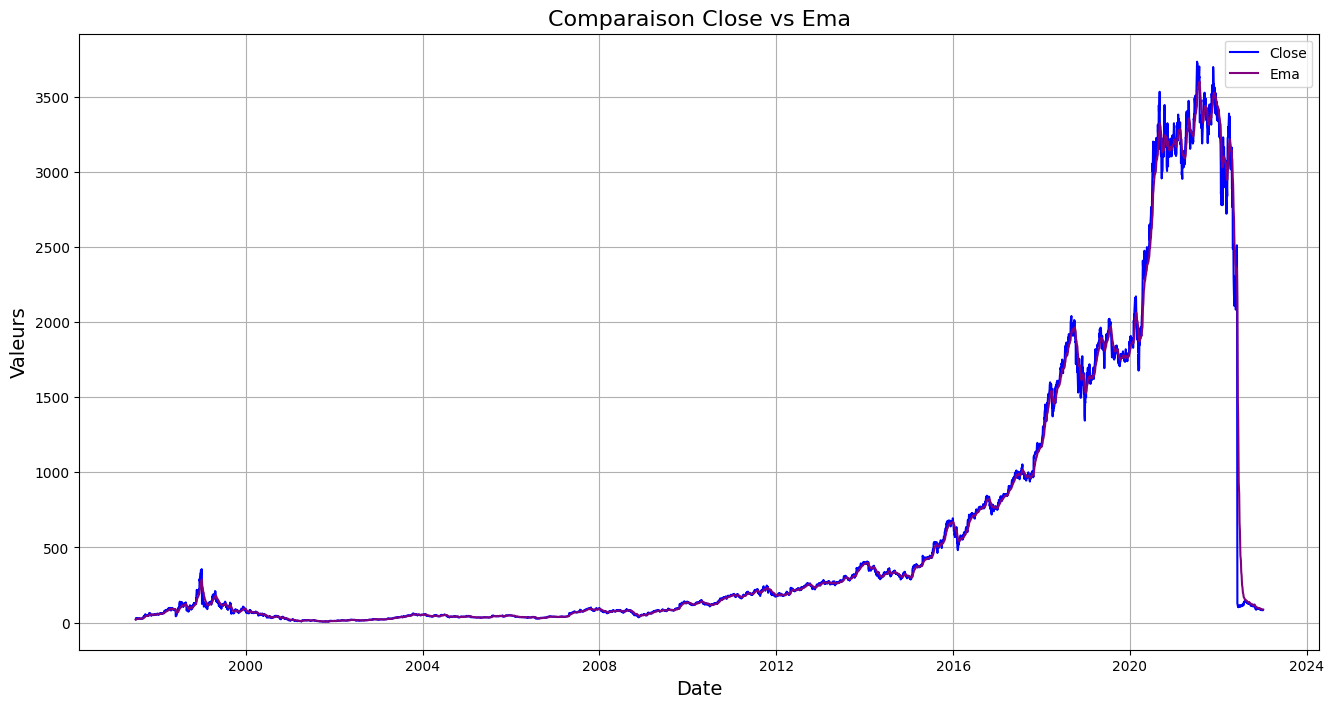

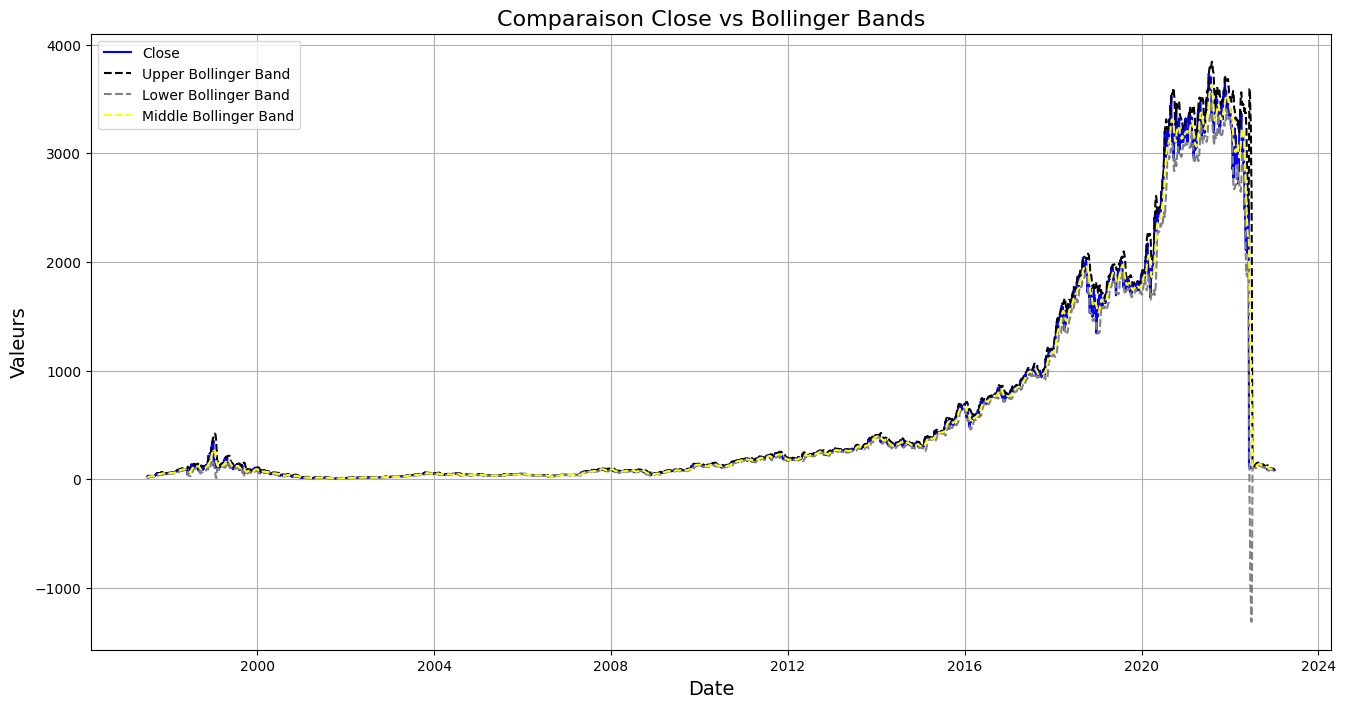

In [20]:
# Liste des indicateurs à tracer
indicators = [('SMA', 'green'), ('RSI', 'orange'), ('MACD', 'red'), ('Ema', 'purple')]

# Pour chaque indicateur, créons une figure
for indicator, color in indicators:
    plt.figure(figsize=(16, 8))
    
    # Commencer par le titre
    plt.title(f"Comparaison Close vs {indicator}", fontsize=16)
    
    # Tracer Close
    plt.plot(df.index, df['Close'], color='blue', label='Close')
    
    # Tracer l'indicateur
    plt.plot(df.index, df[indicator], color=color, label=indicator)
    
    # Label pour l'axe x
    plt.xlabel('Date', fontsize=14)
    
    # Label pour l'axe y
    plt.ylabel('Valeurs', fontsize=14)
    
    # Ajoutons une légende
    plt.legend()
    
    # Affichons la grille
    plt.grid(True)
    
    # Affichons le graphique
    plt.show()

# Créons une figure pour les bandes de Bollinger
plt.figure(figsize=(16,8))

# Commencer par le titre
plt.title('Comparaison Close vs Bollinger Bands', fontsize=16)

# Tracer Close
plt.plot(df.index, df['Close'], color='blue', label='Close')

# Tracer les bandes de Bollinger
plt.plot(df.index, df['UpperBB'], color='black', linestyle='--', label='Upper Bollinger Band')
plt.plot(df.index, df['LowerBB'], color='gray', linestyle='--', label='Lower Bollinger Band')
plt.plot(df.index, df['MiddleBB'], color='yellow', linestyle='--', label='Middle Bollinger Band')

# Label pour l'axe x
plt.xlabel('Date', fontsize=14)

# Label pour l'axe y
plt.ylabel('Valeurs', fontsize=14)

# Ajoutons une légende
plt.legend()

# Affichons la grille
plt.grid(True)

# Affichons le graphique
plt.show()

 ## <font color='brown' face='Time New Roman'>3. Machine Learning</font>

In [21]:
X = df.drop(["Label", "returns"],axis=1)
y = df.Label
X.shape , y.shape

((6418, 9), (6418,))

**<font color='green' face='Time New Roman'>Decision Tree**

**<font color='blue' face='Time New Roman'>Model**

In [225]:
# On va utiliser aussi l'ensemble de validation dans ce cas ,  en redifinant ainsi les X_test , X_train , y_test , y_train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, shuffle=False)

# extract validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=2, shuffle=False)

# Train and evaluate the model
dt = DecisionTreeClassifier(max_depth=3, criterion='gini',random_state = 2).fit(X_train, y_train)

# Prédiction sur l'ensemble d'entraînement pour évaluer la performance du modèle sur les données apprises
y_pred_train = dt.predict(X_train)

# Prédiction sur l'ensemble de validation pour évaluer la performance du modèle sur les donnes de validation
y_pred_val = dt.predict(X_val)

# Prédiction sur l'ensemble de test pour évaluer la performance du modèle sur de nouvelles données
y_pred_test = dt.predict(X_test)

**<font color='blue' face='Time New Roman'>Recall Score**

In [226]:
print("Score de l'ensemble d'entrainment : " , accuracy_score(y_train , y_pred_train))
print("Score de l'ensemble de validation : " , accuracy_score(y_val , y_pred_val))
print("Score de l'ensemble de test : " , accuracy_score(y_test , y_pred_test))

Score de l'ensemble d'entrainment :  0.6131366546061787
Score de l'ensemble de validation :  0.6048020765736535
Score de l'ensemble de test :  0.6035825545171339


**<font color='green' face='Time New Roman'>Logistic Regression**

**<font color='blue' face='Time New Roman'>Model**

In [223]:
# On va utiliser aussi l'ensemble de validation dans ce cas ,  en redifinant ainsi les X_test , X_train , y_test , y_train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, shuffle=False)

# extract validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=2, shuffle=False)
# 'class_weight="balanced"' permet de gérer les classes déséquilibrées en ajustant les poids inversement proportionnels à la fréquence des classes
# 'solver="lbfgs"' est un algorithme d'optimisation et 'max_iter=100' augmente le nombre maximum d'itérations pour la convergence
lr = LogisticRegression(class_weight="balanced",solver='lbfgs', max_iter=1000, random_state = 2).fit(X_train, y_train)

# Prédiction sur l'ensemble d'entraînement pour évaluer la performance du modèle sur les données apprises
y_pred_train = lr.predict(X_train)

# Prédiction sur l'ensemble de validation pour évaluer la performance du modèle sur les données apprises de validation
y_pred_val = lr.predict(X_val)

# Prédiction sur l'ensemble de validation pour évaluer la performance du modèle sur les données apprises de validation
y_pred_test = lr.predict(X_test)

**<font color='blue' face='Time New Roman'>Recall Score**

In [224]:
print("Score de l'ensemble d'entrainment : " , accuracy_score(y_train , y_pred_train))
print("Score de l'ensemble de validation : " , accuracy_score(y_val , y_pred_val))
print("Score de l'ensemble de test : " , accuracy_score(y_test , y_pred_test))

Score de l'ensemble d'entrainment :  0.5967158363484554
Score de l'ensemble de validation :  0.6229720960415315
Score de l'ensemble de test :  0.6035825545171339


**<font color='green' face='Time New Roman'>Random Forest Classifier**

**<font color='blue' face='Time New Roman'>Model**

In [220]:
# On va utiliser aussi l'ensemble de validation dans ce cas ,  en redifinant ainsi les X_test , X_train , y_test , y_train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, shuffle=False)

# extract validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.32, random_state=2, shuffle=False)

# Train and evaluate the model
rf = RandomForestClassifier(n_estimators=3 , random_state=2 ).fit(X_train , y_train)

# Prédiction sur l'ensemble d'entraînement pour évaluer la performance du modèle sur les données apprises
y_pred_train = rf.predict(X_train)

# Prédiction sur l'ensemble de validation pour évaluer la performance du modèle sur les donnes de validation
y_pred_val = rf.predict(X_val)

# Prédiction sur l'ensemble de test pour évaluer la performance du modèle sur de nouvelles données
y_pred_test = rf.predict(X_test)

**<font color='blue' face='Time New Roman'>Score de rappel**

In [221]:
print("Score de l'ensemble d'entrainment : " , recall_score(y_train , y_pred_train))
print("Score de l'ensemble de validation : " , recall_score(y_val , y_pred_val))
print("Score de l'ensemble de test : " , recall_score(y_test , y_pred_test))

Score de l'ensemble d'entrainment :  0.9211448598130841
Score de l'ensemble de validation :  0.7875288683602771
Score de l'ensemble de test :  0.8969072164948454


**<font color='blue' face='Time New Roman'>Rapport de classification**

In [222]:
print("Ensemble d'entrainemnt  classification report:\n", classification_report(y_train, y_pred_train))
print("Ensemble de test  classification report:\n", classification_report(y_test, y_pred_test))

Ensemble d'entrainemnt  classification report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      1779
           1       0.92      0.92      0.92      1712

    accuracy                           0.92      3491
   macro avg       0.92      0.92      0.92      3491
weighted avg       0.92      0.92      0.92      3491

Ensemble de test  classification report:
               precision    recall  f1-score   support

           0       0.66      0.22      0.33       605
           1       0.56      0.90      0.69       679

    accuracy                           0.58      1284
   macro avg       0.61      0.56      0.51      1284
weighted avg       0.61      0.58      0.52      1284



**<font color='blue' face='Time New Roman'>Matrice de confusion**

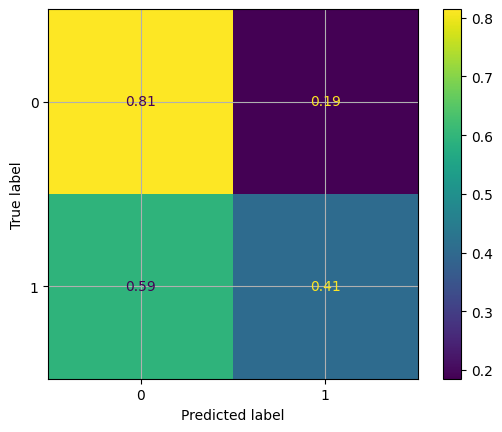

In [227]:
# Calcul de la matrice de confusion normalisée pour l'ensemble d'entraînement
normalized_confusion_matrix_train = confusion_matrix(y_train, y_pred_train, normalize="true")

# Création d'un objet ConfusionMatrixDisplay pour afficher la matrice de confusion
confusion_matrix_display_train = ConfusionMatrixDisplay(confusion_matrix=normalized_confusion_matrix_train)

# Tracage de la matrice de confusion
confusion_matrix_display_train.plot()

# Suppression des lignes de grille
plt.grid(None)

# Affichage de la matrice de confusion
plt.show()

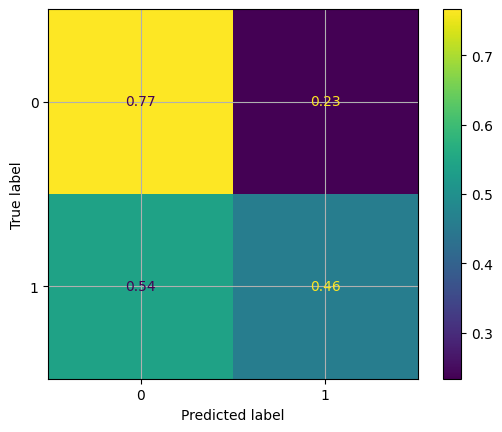

In [228]:
# pour validation maintenant
normalized_confusion_matrix_val = confusion_matrix(y_val, y_pred_val, normalize="true")
confusion_matrix_display_val = ConfusionMatrixDisplay(confusion_matrix=normalized_confusion_matrix_val)
confusion_matrix_display_val.plot()
plt.grid(None)
plt.show()

**<font color='blue' face='Time New Roman'>Courbe ROC**

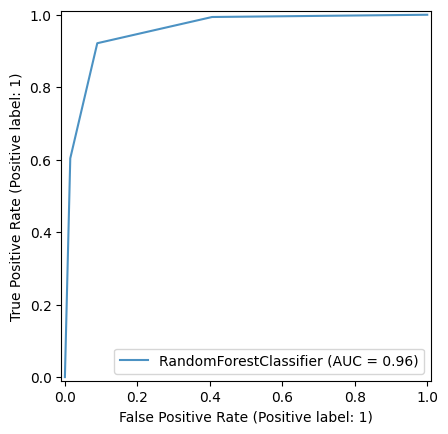

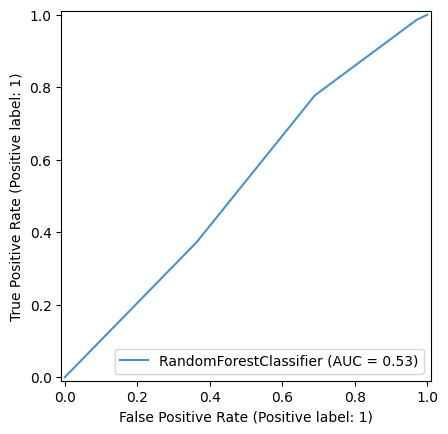

In [234]:
#definition de la fonction pour constuire le graph
def plot_roc_curve(model, X, y):
    # Récupération des axes actuels
    ax = plt.gca()
    
    # Affichage de la courbe ROC à partir de l'estimateur/model
    RocCurveDisplay.from_estimator(model, X, y, ax=ax, alpha=0.8)
    
    # Affichage la courbe ROC
    plt.show()
#Exemple pour le model rf deja implementé pour entrainment
plot_roc_curve(rf, X_train, y_train)
#Exemple pour le model rf deja implementé pour validation
plot_roc_curve(rf, X_val, y_val)

 ## <font color='brown' face='Time New Roman'>4. La validation croisée et réglage des hyperparamètres</font>

**<font color='green' face='Time New Roman'>GridSearchCV**

In [244]:
# Définition des paramètres de recherche
parametres_recherche = {
    "n_estimators": [1, 2, 3],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 3, 5],
    "min_samples_leaf": [1, 2, 3],
    "max_features": ['sqrt', 'log2']
}
# Choix du modèle RandomForestClassifier
modele_rf = RandomForestClassifier(random_state=42)
# Nombre de découpages pour la validation croisée
tscv = TimeSeriesSplit(n_splits=3)
# Utilisation de GridSearchCV pour trouver la meilleure combinaison de paramètres
recherche_hyperparametres = GridSearchCV(estimator=modele_rf, cv=tscv, param_grid=parametres_recherche, scoring='recall')
# Application sur notre ensemble d'entraînement
recherche_hyperparametres.fit(X_train, y_train)
# Meilleure combinaison de paramètres
meilleurs_parametres_rf = recherche_hyperparametres.best_params_

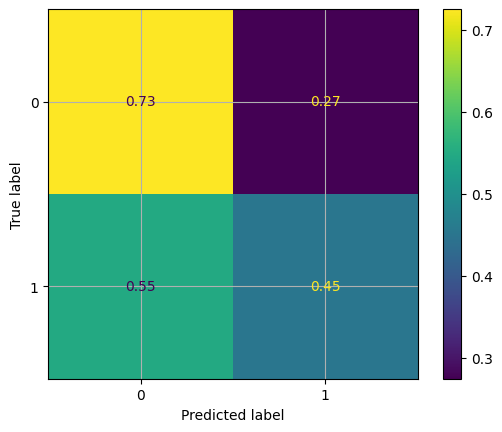

In [251]:
# Entraîner notre modèle et comparer les résultats sur la validation avec/sans réglage des hyperparamètres.
modele_rf_CV = RandomForestClassifier(random_state=42)
modele_rf_CV.set_params(**meilleurs_parametres_rf)  
modele_rf_CV.fit(X_train, y_train)

# Prédiction sur l'ensemble de validation avec le modèle ajusté
y_pred_val_CV_rf = modele_rf_CV.predict(X_val)

# Calculer la matrice de confusion pour l'ensemble de validation avec le modèle ajusté
cf_val_CV_rf = confusion_matrix(y_val, y_pred_val_CV_rf, normalize="true")

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cf_val_CV_rf)
disp.plot()
plt.grid(None)
plt.show()

**<font color='green' face='Time New Roman'>Optuna**

In [254]:
def optimisation_hyperparametres(trial):
    nom_classificateur = trial.suggest_categorical("nom_classificateur", ["LogisticRegression", "SVC", "RandomForest", "KNN"])

    # Sélectionner les modèles et les hyperparamètres
    if nom_classificateur == "LogisticRegression":
        params = {
            "C": trial.suggest_loguniform("C", 1e-2, 10),
            "penalty": trial.suggest_categorical("penalty", ["l2"]),
            "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
            "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear"])
        }
        classifier_obj = LogisticRegression(**params)

    if nom_classificateur == "SVC":
        params = {
            "C": trial.suggest_loguniform("C", 1e-2, 10),
            "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
            "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"])
        }
        classifier_obj = SVC(**params)

    if nom_classificateur == "RandomForest":
        params = {
            "max_depth": trial.suggest_int("max_depth", 2, 8),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 5),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 5),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"])
        }
        classifier_obj = RandomForestClassifier(**params)

    if nom_classificateur == "KNN":
        params = {
            "n_neighbors": trial.suggest_int("n_neighbors", 1, 20),
            "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
            "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"])
        }
        classifier_obj = KNeighborsClassifier(**params)

    # Utiliser TimeSeriesSplit pour la validation croisée et calculer le score de rappel.
    rappel_CV = []
    for train_idx, val_idx in TimeSeriesSplit(n_splits=3).split(X_train):
        X_train_CV = X_train.iloc[train_idx]
        y_train_CV = y_train.iloc[train_idx]
        classifier_obj.fit(X_train_CV, y_train_CV)
        X_val_CV = X_train.iloc[val_idx]
        y_val_CV = y_train.iloc[val_idx]
        y_pred_CV = classifier_obj.predict(X_val_CV)
        rappel_CV.append(recall_score(y_val_CV, y_pred_CV))

    # Renvoyer la fonction objectif à maximiser
    return np.average(rappel_CV)


# Créer une étude Optuna pour optimiser les hyperparamètres du classificateur choisi.
etude = optuna.create_study(direction="maximize")
etude.optimize(optimisation_hyperparametres, n_trials=100)

[I 2024-02-16 19:56:35,856] A new study created in memory with name: no-name-3e73b462-3037-4919-818f-38d1a234a1ba
c:\Users\BUNICE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\BUNICE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/prepr

C:\Users\BUNICE\AppData\Local\Temp\ipykernel_69636\2362758055.py:2: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(etude, ["nom_classificateur"])
C:\Users\BUNICE\AppData\Local\Temp\ipykernel_69636\2362758055.py:5: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(etude, ["max_depth"])
C:\Users\BUNICE\AppData\Local\Temp\ipykernel_69636\2362758055.py:8: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(etude, ["class_weight"])


TypeError: RandomForestClassifier.__init__() got an unexpected keyword argument 'C'

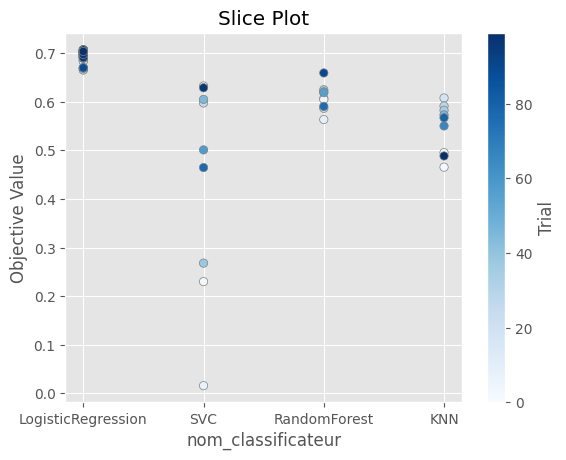

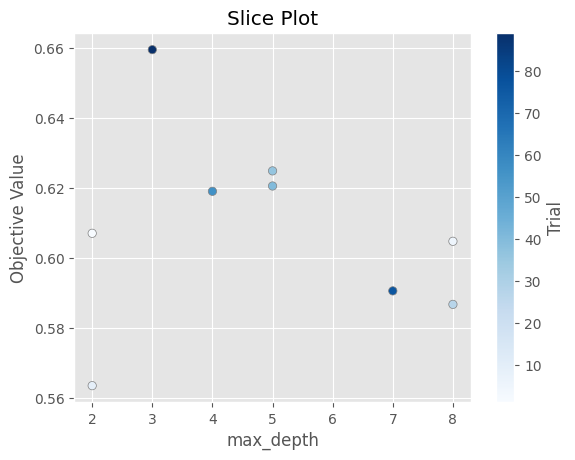

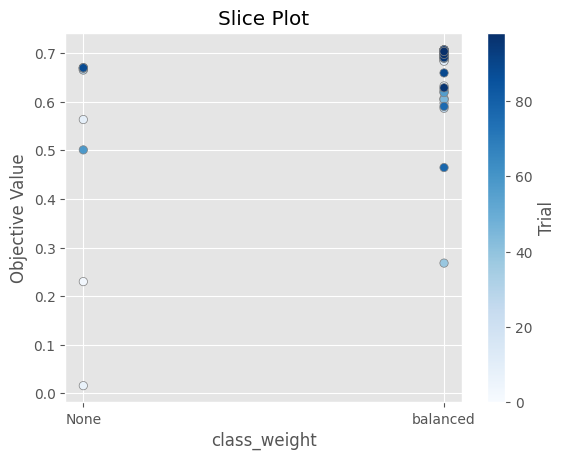

In [255]:
# Créer un graphique 2D de la fonction objectif par rapport aux hyperparamètres pour le paramètre "nom_classificateur" : montrer le meilleur modèle à utiliser
optuna.visualization.matplotlib.plot_slice(etude, ["nom_classificateur"])

# Montrer l'importance de l'ajustement des hyperparamètres sur le score final : profondeur maximale
optuna.visualization.matplotlib.plot_slice(etude, ["max_depth"])

# Montrer l'importance de l'ajustement des hyperparamètres sur le score final : poids de classe
optuna.visualization.matplotlib.plot_slice(etude, ["class_weight"])

# DataFrame Pandas des essais terminés dans l'étude Optuna, trié par ordre décroissant en fonction de la valeur (c'est-à-dire la fonction objectif à maximiser)
donnees_essais = etude.trials_dataframe().sort_values("value", ascending=False)

# Choisir le meilleur modèle avec la meilleure combinaison de paramètres
meilleurs_parametres = etude.best_params
del meilleurs_parametres["nom_classificateur"]
modele_rf_optimal = RandomForestClassifier(**meilleurs_parametres)

 ## <font color='brown' face='Time New Roman'>5. Benchmark</font>

In [262]:
uniform_dm = DummyClassifier(strategy="uniform").fit(X_train, y_train)
y_pred_dummy = uniform_dm.predict(X_test)
print('Test set classification report:\n', classification_report(y_test, y_pred_dummy))

Test set classification report:
               precision    recall  f1-score   support

           0       0.46      0.50      0.48       605
           1       0.52      0.49      0.50       679

    accuracy                           0.49      1284
   macro avg       0.49      0.49      0.49      1284
weighted avg       0.49      0.49      0.49      1284



 ## <font color='brown' face='Time New Roman'>6. Backtesting</font>

In [269]:

df_amzn = pd.read_csv("AMAZON.csv")
df_amzn['Date'] = pd.to_datetime(df_amzn['Date'])
df_amzn.set_index('Date', inplace=True)

predictions = rf.predict(X_test)
donnees_predictions = pd.DataFrame(data=predictions, index=X_test.index, columns=['pred'])

donnees_predictions = donnees_predictions.reset_index()

# Calculer les rendements quotidiens de AMZN
df_amzn['rtn_amzn'] = df_amzn['Close'].pct_change()

# Fusionner les prédictions sur "Date" avec les rendements quotidiens du AMZN
fusion = (
    df_amzn.reset_index()[['Date', 'rtn_amzn']]  # Réinitialiser l'index et sélectionner les colonnes 'Date' et 'rtn_amzn'
    .merge(donnees_predictions, on='Date')  # Fusionner avec les prédictions sur 'Date'
    .assign(pred=lambda df: df['pred'].shift(-1))  # Décaler les prédictions d'une journée, si nécessaire
    .dropna() 
    .assign(
        rtn_overlay=lambda df: df.apply(lambda x: 0 if x["pred"] == 0 else -0.3 * x["rtn_amzn"], axis=1),  # Calculer le rendement de l'overlay
        perf_overlay=lambda df: df["rtn_overlay"].add(1).cumprod().sub(1),  # Calculer la performance de l'overlay
        perf_amzn=lambda df: df["rtn_amzn"].add(1).cumprod().sub(1),  # Calculer la performance du AMZN
        perf_combined=lambda df: (df["rtn_amzn"] + df["rtn_overlay"]).add(1).cumprod().sub(1)  # Calculer la performance combinée
    )
)


print(fusion)

           Date  rtn_amzn  pred  rtn_overlay  perf_overlay  perf_amzn  \
0    2017-11-28 -0.001865   0.0     0.000000      0.000000  -0.001865   
1    2017-11-29 -0.027086   1.0     0.008126      0.008126  -0.028900   
2    2017-11-30  0.013330   1.0    -0.003999      0.004094  -0.015955   
3    2017-12-01 -0.012237   1.0     0.003671      0.007780  -0.027997   
4    2017-12-04 -0.024433   1.0     0.007330      0.015167  -0.051746   
...         ...       ...   ...          ...           ...        ...   
1278 2022-12-27 -0.025924   0.0     0.000000     -0.465137  -0.930559   
1279 2022-12-28 -0.014692   0.0     0.000000     -0.465137  -0.931579   
1280 2022-12-29  0.028844   0.0     0.000000     -0.465137  -0.929605   
1281 2022-12-30 -0.002138   0.0     0.000000     -0.465137  -0.929756   
1282 2023-01-03  0.021667   0.0     0.000000     -0.465137  -0.928234   

      perf_combined  
0         -0.001865  
1         -0.020790  
2         -0.011653  
3         -0.020119  
4         -0.

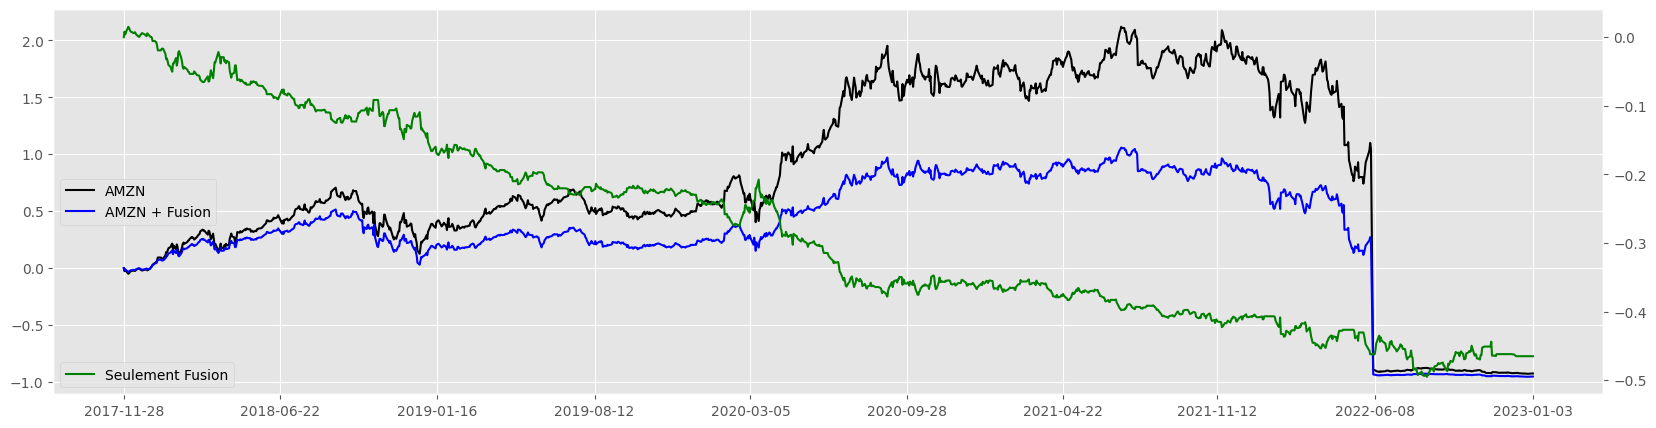

In [272]:
# Créer une liste de graduations pour l'axe des x pour le graphique
indx = np.linspace(0, len(fusion)-1, 10, dtype=int)
xticks = [fusion["Date"].values[i] for i in indx]

# Tracer la courbe de capital pour chaque actif
fig, ax1 = plt.subplots(figsize=(20, 5))

# Instancier un second axe qui partage le même axe des x
ax2 = ax1.twinx()
ax1.plot(fusion["Date"], fusion["perf_amzn"], c='black')
ax1.plot(fusion["Date"], fusion["perf_combined"], c='blue')
ax2.plot(fusion["Date"], fusion["perf_overlay"], c='green')
ax1.legend(["AMZN", "AMZN + Fusion"], loc=6)
ax2.legend(["Seulement Fusion"], loc=3)
plt.xticks(xticks)
plt.grid(visible=False)
plt.show()

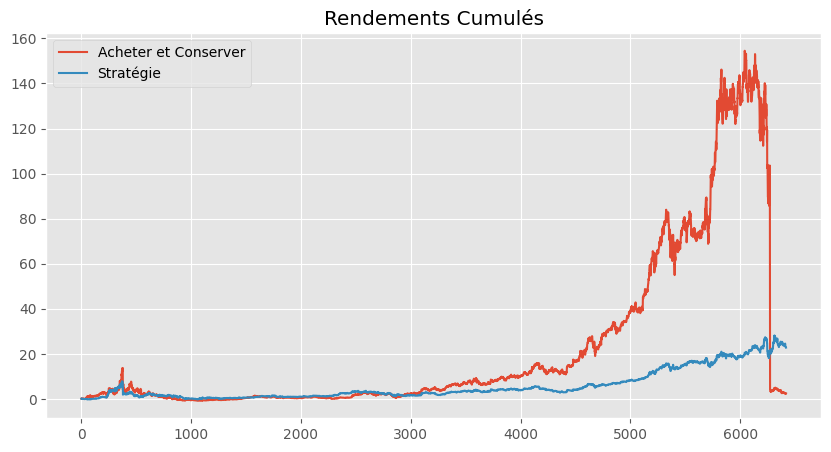

In [273]:
df['predicted_label'] = rf.predict(X)
df['predicted_label'] = np.where(df['predicted_label'] == 1, 'Achat', 'Vente')

df['rendements_quotidiens'] = df['Close'].pct_change()
df['rendements_stratégiques'] = df['rendements_quotidiens'] * df['Label'].shift(1)
df['rendements_stratégiques_cumulés'] = (df['rendements_stratégiques'] + 1).cumprod() - 1
df['rendements_cumulés'] = (df['rendements_quotidiens'] + 1).cumprod() - 1

# Tracer les résultats
plt.figure(figsize=(10,5))
plt.plot(df['rendements_cumulés'], label='Acheter et Conserver')
plt.plot(df['rendements_stratégiques_cumulés'], label='Stratégie')
plt.legend()
plt.title('Rendements Cumulés')
plt.show()
